## Data preprocessing

In [1]:
import numpy as np
import pandas as pd

colnames = ["time", "ID", "DLC", "Data1", \
        "Data2", "Data3", "Data4", "Data5", "Data6", "Data7", "Data8", "Attack"]

nRows = 10000 #number of rows that you want
df = pd.read_csv('gear_dataset.csv', nrows = nRows, sep=',', names=colnames)

uniqueIDs = df['ID'].unique() #26 for the entire dataset

#Drop attack packets
attack = df[df['Attack'] == 'T'].copy()
df.drop(attack.index, axis=0, inplace=True)

#Drop DLC = 2 packets
dlc2 = df[df['DLC'] == 2]
df.drop(dlc2.index, axis=0, inplace=True) #drop all dlc2 indexes

#Pick an ID
id_data= df[df['ID'] == '0140'].copy()

#Just use data values without time, Attack, ID and DLC right now
dataValues = id_data.drop(["time", "Attack", "ID", "DLC"], axis = 1).copy()
dataValues = dataValues.to_numpy()


storage = np.zeros((len(dataValues),64), dtype=int)
for currentRow in np.arange(len(storage)):
    
    tempString = "".join(dataValues[currentRow])
    formatted = format(int(tempString, base=16), "064b")
    storage[currentRow,:] = np.array(list(formatted), dtype=int)

In [2]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [3]:

def overlapping_window (window_size,overlap,seq): # overlap 1 is max. larger number would be less overlap
 
    seq = array([seq[i : i + window_size] for i in range(0, len(seq), overlap)]) 
   
    correct = [len(x)==window_size for x in seq]
    seq = seq[correct]
    seq = np.stack(seq, axis=0 )
    seq = seq.reshape(-1,window_size,1)

    return seq

In [6]:
time_steps = 40
n_rows = storage.shape[0]
n_features = storage.shape[1]
a = np.r_[0:n_rows]
X_train_samples = overlapping_window(time_steps,20,a)
X_train = storage[X_train_samples,:]
X_train = np.squeeze(X_train)
print(X_train.shape)

X_reversed = np.flip(X_train,1)


(20, 40, 64)


In [7]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]
lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

# define Encoder

EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)
lstm1 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(dropout)
lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm1)
encoder_states = [state_h, state_c]

# define Decoder
  
lstm3 =  LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm2,initial_state=encoder_states)
lstm4 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(dense2)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()


Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40, 256)      16640       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 256)      0           dense[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 128)      197120      dropout[0][0]                    
_____________________________________________________________________________________

Epoch 1/100
1/1 - 3s - loss: 0.6562 - val_loss: 0.6125
Epoch 2/100
1/1 - 0s - loss: 0.6132 - val_loss: 0.5740
Epoch 3/100
1/1 - 0s - loss: 0.5745 - val_loss: 0.5384
Epoch 4/100
1/1 - 0s - loss: 0.5401 - val_loss: 0.5069
Epoch 5/100
1/1 - 0s - loss: 0.5063 - val_loss: 0.4779
Epoch 6/100
1/1 - 0s - loss: 0.4788 - val_loss: 0.4522
Epoch 7/100
1/1 - 0s - loss: 0.4505 - val_loss: 0.4276
Epoch 8/100
1/1 - 0s - loss: 0.4272 - val_loss: 0.4076
Epoch 9/100
1/1 - 0s - loss: 0.4044 - val_loss: 0.3862
Epoch 10/100
1/1 - 0s - loss: 0.3845 - val_loss: 0.3684
Epoch 11/100
1/1 - 0s - loss: 0.3662 - val_loss: 0.3531
Epoch 12/100
1/1 - 0s - loss: 0.3510 - val_loss: 0.3400
Epoch 13/100
1/1 - 0s - loss: 0.3374 - val_loss: 0.3278
Epoch 14/100
1/1 - 0s - loss: 0.3253 - val_loss: 0.3170
Epoch 15/100
1/1 - 0s - loss: 0.3132 - val_loss: 0.3047
Epoch 16/100
1/1 - 0s - loss: 0.3035 - val_loss: 0.2955
Epoch 17/100
1/1 - 0s - loss: 0.2935 - val_loss: 0.2881
Epoch 18/100
1/1 - 0s - loss: 0.2859 - val_loss: 0.2807
E

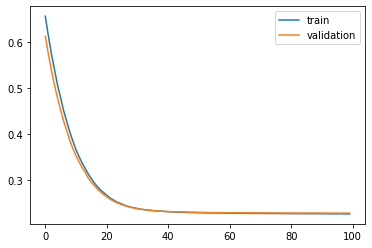

training time = 41.16584515571594 seconds


In [8]:
import time

model = EncoderDecoder
es= EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

s=time.time()
history = model.fit(X_train[0:10,:,:], X_reversed[0:10,:,:], validation_data=(X_train[10:21,:,:], X_reversed[10:21,:,:]), epochs=1000, verbose=2, shuffle=False, callbacks = [es])
e=time.time()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')